This file was created using [Jupyter Notebook](http://jupyter.org/).

First, we need to import numpy, matplotlib, timeit and the collector.

In [17]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import treadmill
import timeit

Here we define a function for rendering a plot showing the size of the input and the time it took to process it.

In [18]:
def draw_plot(sizes, times):
    z = np.polyfit(sizes, times, 1)
    p = np.poly1d(z)
    
    plt.xlabel('Input size')
    plt.ylabel('Time')
    plt.plot(sizes, times, '.')
    plt.plot(sizes, p(sizes), 'r--')
    plt.show()

The first analysis simply constructs an empty heap with a number of initial cells. It allocates cells repeatedly, not storing them as roots. We can see that with increasing heap size the time stays constant, therefore allocating new cells is `O(1)`.

This code creates heaps of size 100, 200, 300, ..., 20000 cells and then calls `allocate` 50 times. Scanning will never start, since `scan_threshold` is set to 0.

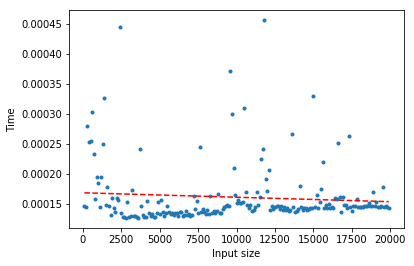

In [19]:
def create_heap(size):
    return treadmill.Heap(get_roots=lambda: [], get_children=lambda x: [], initial_size=size, scan_threshold=0)

sizes = range(100, 20000, 100)
times = []

for size in sizes:
    time = timeit.timeit('heap.allocate()', setup='heap = create_heap(size)', number=50, globals=globals())
    times.append(time)

draw_plot(sizes, times)

Here we do the same as before, but with two differences:

1. `scan_threshold` is set to 1, meaning scanning will start every time.
2. We allocate 30 cells that are declared as roots before timing allocation.

We can see that the time is still constant with increasing heap size. This shows that scanning the heap while allocating is `O(1)` even when the heap size is increasing.

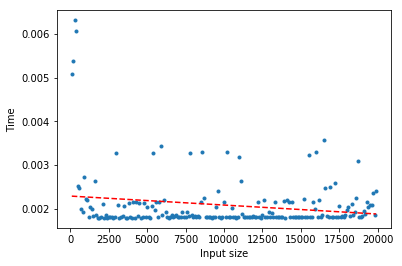

In [20]:
def create_heap(size):
    roots = []
    
    def get_roots():
        return roots
    
    heap = treadmill.Heap(get_roots=get_roots,
                          get_children=lambda obj: [], 
                          initial_size=size, 
                          scan_threshold=1, 
                          scan_step_size=10)
    
    roots = [heap.allocate() for _ in range(30)]
    
    return heap

sizes = range(100, 20000, 100)
times = []

for size in sizes:
    time = timeit.timeit('heap.allocate()', setup='heap = create_heap(size)', number=50, globals=globals())
    times.append(time)

draw_plot(sizes, times)

To check that the size of the objects that are garbage collected does not affect the performance, we can construct linked lists with increasing sizes.

For each list size, we first create a heap with the initial size twice the size of the list, and `scan_threshold` 0.5. This is so that scanning does not begin until we create the list (i.e. until half the size of the heap is allocated).

Then we create a list and make sure it is marked as a root, so that it is not collected. When the list is created, we unmark it as a root, making it available to be collected.

Once we have the garbage list on the heap, we begin timing the calls to `allocate`. These will remain `O(1)` even while scanning the object, as only a fixed number of cells are scanned per one call.

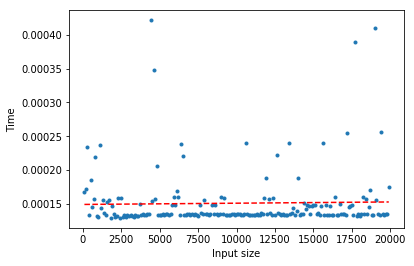

In [21]:
import linked_list

def create_heap(size):
    linked_list.heap = treadmill.Heap(heap_roots, heap_children, initial_size=size*2, scan_threshold=0.5, scan_step_size=10)

    # create the list, adding it as a root to make sure it is not collected
    linked_list.create_list(size)
    
    # remove the list from roots so that it can be collected
    linked_list.episcopal_list = None
    
    return linked_list.heap

object_sizes = range(100, 20000, 100)
times = []

for object_size in object_sizes:
    time = timeit.timeit('heap.allocate()', setup='heap = create_heap(object_size)', number=50, globals=globals())
    times.append(time)

draw_plot(object_sizes, times)

One of the bad cases of this implementation is that when it starts scanning, it goes through all roots at once. Therefore the call to `allocate` that starts scanning will be `O(n)` where n is the number of roots.

We can see this behaviour below. As the number of roots increases, the time increases linearly.

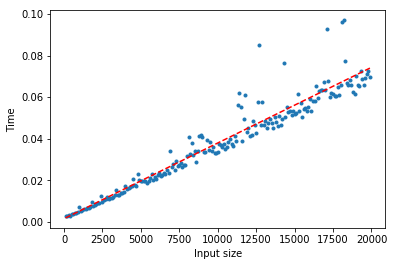

In [22]:
def create_heap(size, num_roots):
    roots = []
    
    def get_roots():
        return roots
    
    heap = treadmill.Heap(get_roots=get_roots,
                          get_children=lambda obj: [], 
                          initial_size=size, 
                          scan_threshold=1, 
                          scan_step_size=10)
    
    roots = [heap.allocate() for _ in range(num_roots)]
    
    return heap

heap_size = 30000
root_sizes = range(100, 20000, 100)
times = []

for root_size in root_sizes:
    time = timeit.timeit('heap.allocate()', setup='heap = create_heap(heap_size, root_size)', number=50, globals=globals())
    times.append(time)

draw_plot(root_sizes, times)